# How to train your own word vector embeddings with Keras

Many tasks require embeddings or domain-specific vocabulary that pre-trained models based on a generic corpus may not represent well or at all. Standard word2vec models are not able to assign vectors to out-of-vocabulary words and instead use a default vector that reduces their predictive value.

E.g., when working with industry-specific documents, the vocabulary or its usage may change over time as new technologies or products emerge. As a result, the embeddings need to evolve as well. In addition, corporate earnings releases use nuanced language not fully reflected in Glove vectors pre-trained on Wikipedia articles.

We will illustrate the word2vec architecture using the keras library that we will introduce in more detail in the next chapter and the more performant gensim adaptation of the code provided by the word2vec authors. 

To illustrate the word2vec network architecture, we use the Financial News data that we first introduced in chapter 14 on Topic Modeling. 

## Imports

In [1]:
%matplotlib inline
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.callbacks import Callback, TensorBoard

### Settings

In [2]:
sns.set_style('whitegrid')
pd.set_option('float_format', '{:,.2f}'.format)
np.random.seed(42)

### Paths

In [47]:
news_path = Path('data', 'fin_news')
data_path = news_path / 'data'
analogy_path = Path('data', 'analogies', 'analogies-en.txt')

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

## `word2vec` - skipgram Architecture using Keras

### Settings

In [5]:
LANGUAGE = 'en'
SAMPLE_SIZE=.5              # portion of sentences to use for model
NGRAMS = 3                  # Longest ngram in text
MIN_FREQ = 10

In [6]:
SAMPLING_FACTOR = 1e-4
WINDOW_SIZE = 3
EMBEDDING_SIZE = 300
EPOCHS = 1
BATCH_SIZE = 2500

In [7]:
# Set up validation
VALID_SET = 10      # Random set of words to get nearest neighbors for
VALID_WINDOW = 150  # Most frequent words to draw validation set from
NN = 10             # Number of nearest neighbors for evaluation

valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)

In [8]:
FILE_NAME = f'articles_{NGRAMS}_grams.txt'
file_path = data_path / FILE_NAME

In [9]:
tb_path = news_path / 'tensorboard'
if not tb_path.exists():
    tb_path.mkdir(parents=True, exist_ok=True)

### Build Data Set

#### Tokens to ID

1. Extract the top *n* most common words to learn embeddings
2. Index these *n* words with unique integers
3. Create an `{index: word}` dictionary
4. Replace the *n* words with their index, and a dummy value `UNK` elsewhere

In [10]:
sentences = file_path.read_text().split('\n')
words = ' '.join(np.random.choice(sentences, size=int(.5*len(sentences)), replace=False)).split()

In [11]:
# Get (token, count) tuples for tokens meeting MIN_FREQ 
token_counts = [t for t in Counter(words).most_common() if t[1] >= MIN_FREQ]
tokens, counts = list(zip(*token_counts))

# create id-token dicts & reverse dicts
id_to_token = pd.Series(tokens, index=range(1, len(tokens) + 1)).to_dict()
id_to_token.update({0: 'UNK'})
token_to_id = {t:i for i, t in id_to_token.items()}
data = [token_to_id.get(word, 0) for word in words]

In [12]:
vocab_size = len(token_to_id)

In [13]:
vocab_size

59617

In [14]:
s = pd.Series(data).value_counts().reset_index()
s.columns = ['id', 'count']
s['token'] = s.id.map(id_to_token)

In [15]:
s.sort_values('count', ascending=False).head(10)

,id,count,token
0,0,411047,UNK
1,1,171157,company
2,2,168115,million
3,3,144088,said
4,4,110774,year
5,5,106468,quarter
6,6,82508,financial
7,7,78595,reuters
8,8,73047,net
9,9,72307,new


In [16]:
s['count'].sum()

17391040

In [17]:
s.sort_values('id').token.dropna().to_csv(tb_path / 'meta.tsv', index=False)

#### Analogies to ID

In [18]:
df = pd.read_csv(analogy_path, header=None, squeeze=True)
categories = df[df.str.startswith(':')]
analogies = df[~df.str.startswith(':')].str.split(expand=True)
analogies.columns = list('abcd')

In [19]:
analogies.head()

,a,b,c,d
1,athens,greece,baghdad,iraq
2,athens,greece,bangkok,thailand
3,athens,greece,beijing,china
4,athens,greece,berlin,germany
5,athens,greece,bern,switzerland


In [20]:
analogies_id = analogies.apply(lambda x: x.map(token_to_id))
analogies_id.notnull().all(1).sum()/len(analogies_id)

0.7269218651543793

### Generate Sampling Probabilities

There is an alternative, faster scheme than the traditional SoftMax loss function called [Noise Contrastive Estimation (NCE)](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Instead of getting the softmax probability for all possible context words, randomly sample 2-20 possible context words and evaluate the probability only for these.

**SAMPLING_FACTOR**: used for generating the `sampling_table` argument for `skipgrams`. 

`sampling_table[i]` is the probability of sampling the word i-th most common word in a dataset

The sampling probabilities are generated according
to the sampling distribution used in word2vec:

$p(\text{word}) = \min\left(1, \frac{\sqrt{\frac{\text{word frequency}}{\text{sampling factor}}}}{\frac{\text{word frequency}}{\text{sampling factor}}}\right)$

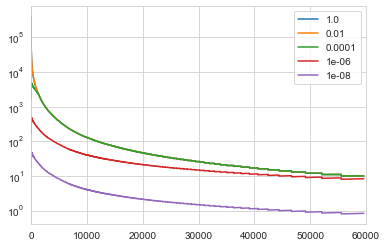

In [21]:
df = s['count'].to_frame('freq')
factors = [1, 1e-2, 1e-4, 1e-6, 1e-8]
for f in factors:
    sf = make_sampling_table(vocab_size, sampling_factor=f)
    df[f] = df.freq.mul(sf)
df.loc[:, factors].plot(logy=True, xlim=(0, 60000));

In [22]:
sampling_table = make_sampling_table(vocab_size, sampling_factor=SAMPLING_FACTOR/10)

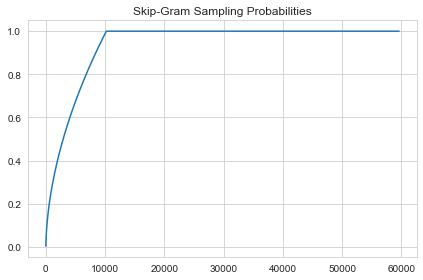

In [23]:
pd.Series(sampling_table).plot(title='Skip-Gram Sampling Probabilities')
plt.tight_layout();

### Generate target-context word pairs

In [24]:
pairs, labels = skipgrams(sequence=data,
                          vocabulary_size=vocab_size,
                          window_size=WINDOW_SIZE,
                          sampling_table=sampling_table,
                          negative_samples=1.0,
                          shuffle=True)

print('{:,d} pairs created'.format(len(pairs)))

62,370,408 pairs created


In [25]:
target_word, context_word = np.array(pairs, dtype=np.int32).T
labels = np.array(labels, dtype=np.int8)
del pairs

In [26]:
target_word[:5]

array([59011, 26664,   733,  2361, 11892], dtype=int32)

In [27]:
df = pd.DataFrame({'target': target_word[:5], 'context': context_word[:5], 'label': labels[:5]})
df

,target,context,label
0,59011,738,1
1,26664,157,1
2,733,41495,0
3,2361,30,1
4,11892,579,1


In [28]:
pd.Series(labels).value_counts()

1    31185204
0    31185204
dtype: int64

In [29]:
with pd.HDFStore(news_path / 'data.h5') as store:
    store.put('id_to_token', pd.Series(id_to_token))
    store.put('pairs', pd.DataFrame({'target' : target_word,
                                     'context': context_word},
                                    columns=['target', 'context']))

### Define Keras Model Components

#### Scalar Input Variables

In [30]:
input_target = Input((1,), name='target_input')
input_context = Input((1,), name='context_input')

#### Shared Embedding Layer

In [31]:
embedding = Embedding(input_dim=vocab_size,
                      output_dim=EMBEDDING_SIZE,
                      input_length=1,
                      name='embedding_layer')

In [32]:
target = embedding(input_target)
target = Reshape((EMBEDDING_SIZE, 1), name='target_embedding')(target)

context = embedding(input_context)
context = Reshape((EMBEDDING_SIZE, 1), name='context_embedding')(context)

#### Create Similarity Measure

In [33]:
dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,), name='similarity')(dot_product)

#### Sigmoid Output Layer

In [34]:
output = Dense(units=1, activation='sigmoid', name='output')(dot_product)

#### Compile Training Model

In [35]:
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

#### Display Architecture

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 300)       17885100    target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 300, 1)       0           embedding_layer[0][0]        

#### Validation Model

In [37]:
similarity = Dot(normalize=True, 
                 axes=1, 
                 name='cosine_similarity')([target, context])

In [38]:
# create a secondary validation model to run our similarity checks during training
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)

In [39]:
validation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 300)       17885100    target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 300, 1)       0           embedding_layer[0][0]      

![Keras Graph](https://s3.amazonaws.com/applied-ai/images/keras_graph_tensorboard.png)

### Create Keras Callbacks

####  Nearest Neighors & Analogies

In [40]:
test_set = analogies_id.dropna().astype(int)
a, b, c, actual = test_set.values.T
actual = actual.reshape(-1, 1)
n_analogies = len(actual)

In [41]:
class EvalCallback(Callback):
        
    def on_train_begin(self, logs={}):
        self.eval_nn()
        self.test_analogies()

    def on_train_end(self, logs={}):
        self.eval_nn()

    def on_epoch_end(self, batch, logs={}):
        self.test_analogies()

    @staticmethod
    def test_analogies():
        print('\nAnalogy Accuracy:\n\t', end='')
        embeddings = embedding.get_weights()[0]
        target = embeddings[c] + embeddings[b] - embeddings[a]
        neighbors = np.argsort(cdist(target, embeddings, metric='cosine'))
        match_id = np.argwhere(neighbors == actual)[:, 1]
        print('\n\t'.join(['Top {}: {:.2%}'.format(i, (match_id < i).sum() / n_analogies) for i in [1, 5, 10]]))

    def eval_nn(self):
        print('\n{} Nearest Neighbors:'.format(NN))
        for i in range(VALID_SET):
            valid_id = valid_examples[i]
            valid_word = id_to_token[valid_id]
            similarity = self._get_similiarity(valid_id).reshape(-1)
            nearest = (-similarity).argsort()[1:NN + 1]
            neighbors = [id_to_token[nearest[n]] for n in range(NN)]
            print('{}:\t{}'.format(valid_word, ', '.join(neighbors)))            
        
    @staticmethod
    def _get_similiarity(valid_word_idx):
        target = np.full(shape=vocab_size, fill_value=valid_word_idx)
        context = np.arange(vocab_size)
        return validation_model.predict([target, context])


evaluation = EvalCallback()

#### Tensorboard Callback

Currently tensorflow has a [bug](https://github.com/tensorflow/tensorflow/issues/32902) that prevents metadata from working. The GitHub issue points to a simple fix that you can make to the tensorflow source code, just search for the culprit line and change accordingly until a later release remedies this problem.

In [42]:
tensorboard = TensorBoard(log_dir=str(tb_path),
                          write_graph=True,
                          embeddings_freq=1,
                          embeddings_metadata={'embedding_layer': 
                                               str(tb_path / 'meta.tsv')})

### Train Model

In [43]:
loss = model.fit(x=[target_word, context_word],
                 y=labels,
                 shuffle=True,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[evaluation, tensorboard])

model.save(str(path / 'skipgram_model.h5'))

Train on 62370408 samples

10 Nearest Neighbors:
loss:	hubbard, deadline, denison, designs_builds, gulf_mexico, ref, retrieval, wastewater, hewlett_packard_enterprise, autonomously
non:	malaysia_development_berhad, twitter_facebook_instagram, pare, exercise_restraint, cppib, chromatography, equipping, jittery, defects, kingmaker
service:	lesbos, formulations, emaar_properties, salomon_brothers, elected, louis_dreyfus, inclined, richard_lough, nudging, pinterest
announced:	polished, pfizer, stoke_anti, canton_ohio, die, deepening, instruments, compassionate, susana_vera, redevelopments
ebitda:	hamas, embarked, timeline, protests, harborone_bancorp, suicide_bombing, jqh, mohamed_junayd, staged, glp
december:	caa, heavy_hitters, possesses, n_m, hotbed, bd, melting, earthquake, buoyed, yoghurt
securities:	lres, ski_resort, tv_azteca, executed, t_cells, coolest, sepsis, crackdown_riskier, frequently_always_identified, freddie_mac_multifamily
result:	barzani, unaccompanied, rusal_krasnoyarsk

NameError: name 'path' is not defined

In [44]:
model.save(str(news_path / 'keras' / 'skipgram_model.h5'))

In [48]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
%tensorboard --logdir data/fin_news/tensorboard/train

## Resources

- [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf?)
- [Sebastian Ruder's Blog](http://ruder.io/word-embeddings-1/)